In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [3]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Summary SeqProp Target/Max Cut analysis</h2>

In [4]:
unique_experiments = seq_df.query("experiment == 'max_cut'")['subexperiment'].unique()

seq_df_filtered = seq_df.query("mean_total_count >= 100 and n_barcodes >= 5")

cut_df_filtered = seq_df.query("experiment == 'max_cut' and mean_total_count >= 10").copy()

#Map and evaluate sequences
def eval_logloss(cut_prob, target_pos) :
    target = np.zeros(cut_prob.shape[0])
    target[target_pos] = 0.8
    target[target_pos - 1] = 0.10
    target[target_pos + 1] = 0.10
    
    ent = -np.dot(target, np.log((cut_prob + 0.001) / np.sum(cut_prob + 0.001)))
    
    return ent

start_pos = 58
end_pos = 108

cut_poses = np.arange(end_pos - start_pos) + (start_pos - 56)

true_cut_column = 'cut_prob_true'
pred_cut_column = 'cut_prob_pred'

avg_position_true = []
avg_position_pred = []
cut_probs_true = []
cut_probs_pred = []
log_loss = []
for index, row in cut_df_filtered.iterrows() :
    
    cut_prob_true = np.ravel(row[true_cut_column])
    cut_prob_true = cut_prob_true[start_pos:end_pos] / np.sum(cut_prob_true[start_pos:end_pos])
    cut_probs_true.append(cut_prob_true)

    cut_prob_pred = np.ravel(row[pred_cut_column])
    cut_prob_pred = cut_prob_pred[start_pos:end_pos] / np.sum(cut_prob_pred[start_pos:end_pos])
    cut_probs_pred.append(cut_prob_pred)
    
    avg_pos_true = np.dot(cut_prob_true, (np.arange(cut_prob_true.shape[0]) + start_pos))
    avg_pos_pred = np.dot(cut_prob_pred, (np.arange(cut_prob_pred.shape[0]) + start_pos))
    avg_position_true.append(avg_pos_true)
    avg_position_pred.append(avg_pos_pred)
    
    cut_pos_caught = False
    for cut_pos in [60, 65, 70, 75, 80, 85, 90, 95, 100] :
        if str(cut_pos) in row['subexperiment'] :            
            log_loss.append(eval_logloss(np.copy(cut_prob_true), cut_pos - 55 - (start_pos - 56)))
            
            cut_pos_caught = True
            break
    
    if not cut_pos_caught :
        log_loss.append(0)
    

cut_df_filtered['proxcut_prob_true'] = cut_probs_true
cut_df_filtered['proxcut_prob_pred'] = cut_probs_pred
cut_df_filtered['avgpos_true'] = avg_position_true
cut_df_filtered['avgpos_pred'] = avg_position_pred
cut_df_filtered['loss_logloss'] = log_loss

cut_snv_df_filtered = cut_df_filtered.query("variant == 'snv'").copy()
cut_df_filtered = cut_df_filtered.query("variant != 'snv'").copy()

print("Total number of Max Cut sequences = " + str(len(cut_df_filtered)))


df_human = seq_df_filtered.query("experiment == 'clinvar_wt' and variant == 'wt'")
human_cutprobs = np.array(df_human[true_cut_column].values.tolist())[:, start_pos:end_pos]
human_cutprobs = human_cutprobs / np.sum(human_cutprobs, axis=1).reshape(-1, 1)

human_cutprob = np.mean(human_cutprobs, axis=0)

objective_poses = [5, 10, 15, 20, 25, 30, 35, 40, 45]

Total number of Max Cut sequences = 1274


<h2>Objective cut precision per subexperiment</h2>

/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


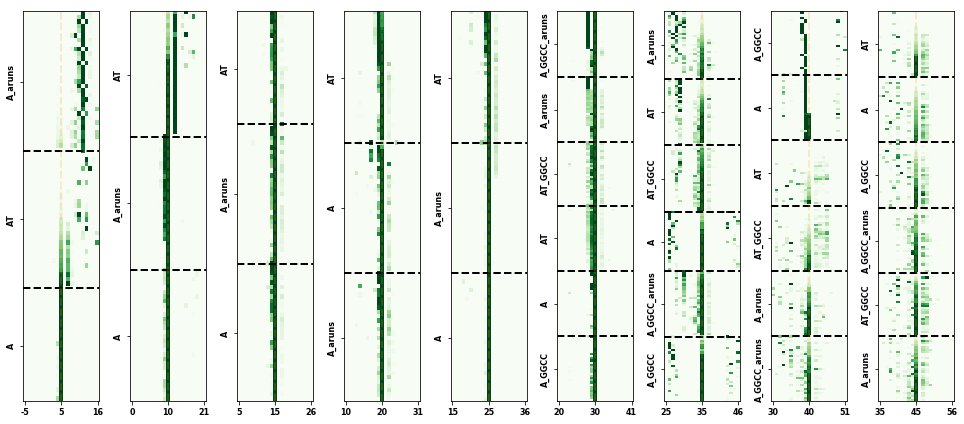

In [5]:

save_figs = False
print_verbose = False

cut_to_experiment = {}

pos_shift = 55
for cut_pos in [60, 65, 70, 75, 80, 85, 90, 95, 100] :
    cut_to_experiment[cut_pos - pos_shift] = []
    for unique_experiment in unique_experiments :
        if str(cut_pos) in unique_experiment :
            cut_to_experiment[cut_pos - pos_shift].append(unique_experiment)

#Detailed view per subexperiment

fig, ax = plt.subplots(1, len(cut_to_experiment), figsize=(1.5 * len(cut_to_experiment), 6))

subexperiment_blacklist = ['ent']

cut_pos_i = None
cut_pos = None

obj_pos_i = 0
for obj_pos, _ in sorted(cut_to_experiment.items(), key=lambda kv: kv[0]) :
    
    cut_result_dict = {}
    
    total_n_obj_pos_seqs = 0
    
    for subexperiment in cut_to_experiment[obj_pos] :
        n_subexp_seqs = len(np.nonzero(cut_df_filtered['subexperiment'] == subexperiment)[0])
        if print_verbose :
            print("Objective position = " + str(obj_pos) + ", subexperiment = " + subexperiment + ", # of sequences = " + str(n_subexp_seqs))
        total_n_obj_pos_seqs += n_subexp_seqs
        
        blacklisted = False
        for subexp_keyword in subexperiment_blacklist :
            if subexp_keyword in subexperiment :
                blacklisted = True
                break
        if blacklisted :        
            continue
    
        keep_index = np.nonzero(cut_df_filtered['subexperiment'] == subexperiment)[0]
        prox_prob = np.array(cut_df_filtered.iloc[keep_index]['proxcut_prob_true'].values.tolist())
    
        sort_index = np.argsort(np.ravel(cut_df_filtered.iloc[keep_index]['loss_logloss'].values))[::-1]
        prox_prob = prox_prob[sort_index, :]
        
        cut_result_dict[subexperiment] = {}
        cut_result_dict[subexperiment]['cut_probs'] = prox_prob
        cut_result_dict[subexperiment]['loss'] = np.mean(cut_df_filtered.iloc[keep_index]['loss_logloss'].values)
    
    if print_verbose :
        print("Objective position = " + str(obj_pos) + ", Total # of sequences = " + str(total_n_obj_pos_seqs))

    cut_probs = []
    cut_label_coords = []
    prev_label_coords = [0]
    cut_labels = []
    
    objective_pos = 0
    for subexperiment, vals in sorted(cut_result_dict.items(), key=lambda kv: kv[1]['loss'])[::-1] :
        prox_prob = vals['cut_probs']
        
        objective_pos = int(subexperiment.split('_')[-1]) - 55 + 10
    
        prox_prob = np.concatenate([np.zeros((prox_prob.shape[0], 10)), prox_prob, np.zeros((prox_prob.shape[0], 10))], axis=1)
    
        cut_probs.append(prox_prob[:, objective_pos - 10 - cut_poses[0]: objective_pos + 11 - cut_poses[0]])
        
        cut_label_coords.append(prev_label_coords[-1] + float(prox_prob.shape[0]) / 2.)
        prev_label_coords.append(prev_label_coords[-1] + float(prox_prob.shape[0]))
        cut_labels.append('_'.join(subexperiment.split('_')[:-1]))
    
        ax[obj_pos_i].axhline(y=prev_label_coords[-1], color='black', linewidth=2, linestyle='--')

    cut_probs = np.vstack(cut_probs)

    ax[obj_pos_i].imshow(cut_probs, cmap='Greens', vmin=0.05, vmax=0.3, aspect='auto')
    
    ax[obj_pos_i].axvline(x=10, color='orange', linewidth=2, linestyle='--', alpha=0.2)
    
    ax[obj_pos_i].set_xticks([0, 10, 20])
    ax[obj_pos_i].set_xticklabels([objective_pos - 20, objective_pos - 10, objective_pos + 1], fontsize=8, fontweight='bold', ha='center', va='top')
    
    ax[obj_pos_i].set_yticks(cut_label_coords)
    ax[obj_pos_i].set_yticklabels(cut_labels, fontsize=8, fontweight='bold', rotation=90, ha='right', va='center')
    
    obj_pos_i += 1


plt.tight_layout()

if save_figs :
    plt.savefig('cut_subexperiment_map.png', transparent=True, dpi=150)
    plt.savefig('cut_subexperiment_map.svg')
    plt.savefig('cut_subexperiment_map.eps')

plt.show()


<h2>Summary Max Cut analysis (all subexperiments)</h2>

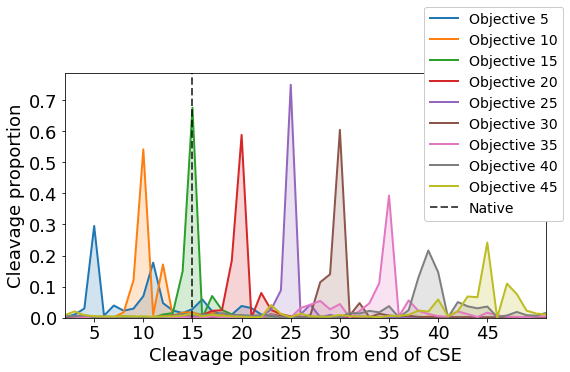

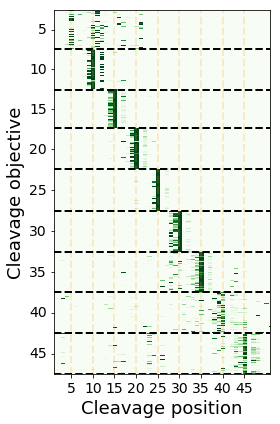

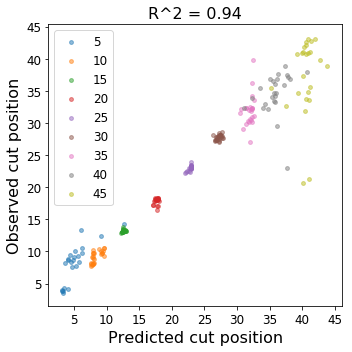

In [6]:
#Mean statistics over all subexperiments

cut_df_to_use = cut_df_filtered.loc[cut_df_filtered.subexperiment.str.contains('GGCC') | cut_df_filtered.subexperiment.str.slice(start=-2).isin(['60', '65', '70', '75', '80'])]

plot_cut_profile(cut_df_to_use, cut_to_experiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=None)#save_fig_name='cut_profile_all_subexps'
plot_cut_map(cut_df_to_use, cut_to_experiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=100)#save_fig_name='cut_map_all_subexps'
plot_position_scatter(cut_df_to_use, cut_to_experiment, cut_poses, objective_poses, human_cutprob, variant_filter="variant == 'wt'", figsize=(5, 5), save_fig_name=None, fig_dpi=150)#save_fig_name='avgcut_pred_vs_true_all_subexps'


<h2>Summary Max Cut analysis ('A' subexperiment)</h2>

Mean cut profile


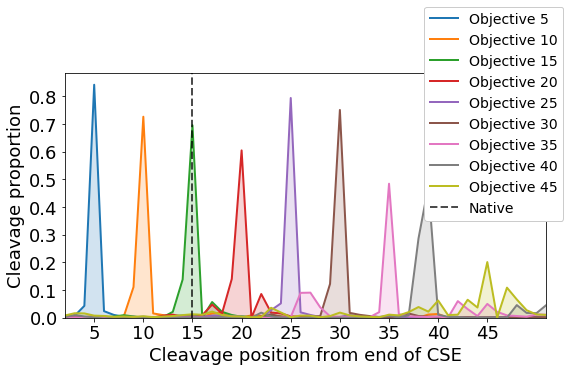

Max cut profile


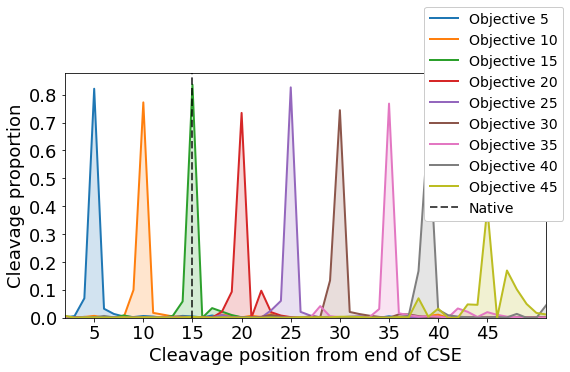

Mean cut map


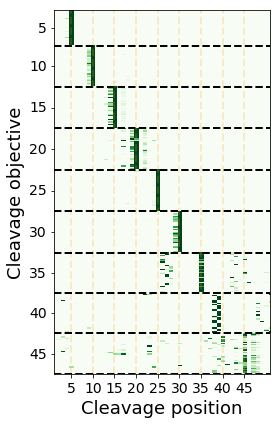

Max cut map


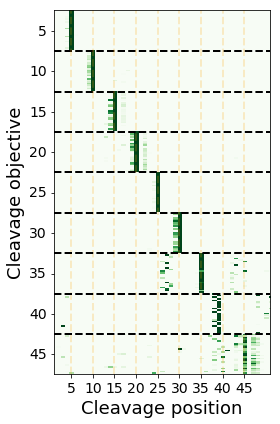

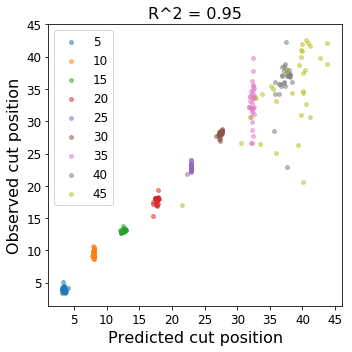

In [7]:
#Mean and Max statistics over A subexperiments

cut_nt = 'A'
aruns_objective = ''
ggcc_objective = '_GGCC'
cut_to_subexperiment = {
    5 : [cut_nt + aruns_objective + '_60', cut_nt + aruns_objective + '_ent_60'],
    10 : [cut_nt + aruns_objective + '_65', cut_nt + aruns_objective + '_ent_65'],
    15 : [cut_nt + aruns_objective + '_70', cut_nt + aruns_objective + '_ent_70'],
    20 : [cut_nt + aruns_objective + '_75', cut_nt + aruns_objective + '_ent_75'],
    25 : [cut_nt + aruns_objective + '_80', cut_nt + aruns_objective + '_ent_80'],
    30 : [cut_nt + ggcc_objective + aruns_objective + '_85', cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    35 : [cut_nt + ggcc_objective + aruns_objective + '_90', cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    40 : [cut_nt + ggcc_objective + aruns_objective + '_95', cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    45 : [cut_nt + ggcc_objective + aruns_objective + '_100', cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
}

print('Mean cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=None)#save_fig_name='cut_profile_subexp_a_mean'
print('Max cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=5)#save_fig_name='cut_profile_subexp_a_max'

print('Mean cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=100)#save_fig_name='cut_map_all_subexp_a_mean'
print('Max cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=25)#save_fig_name='cut_map_all_subexp_a_max'

plot_position_scatter(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, variant_filter="variant == 'wt' or variant == 'sampled'", figsize=(5, 5), save_fig_name=None, fig_dpi=150)#save_fig_name='avgcut_pred_vs_true_subexp_a'


<h2>Summary Max Cut analysis ('AT' subexperiment)</h2>

Mean cut profile


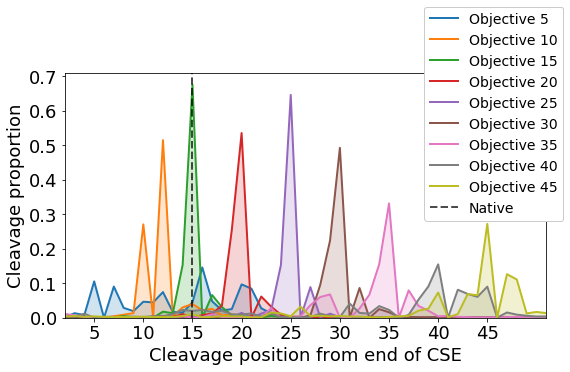

Max cut profile


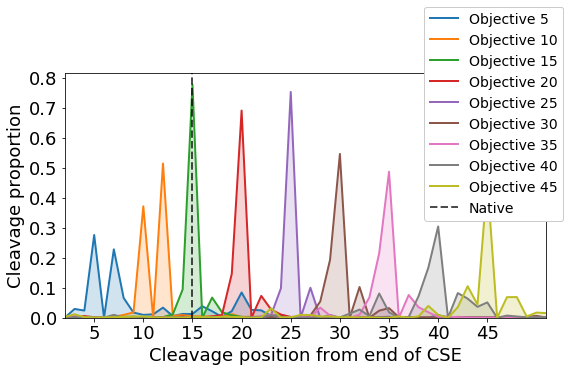

Mean cut map


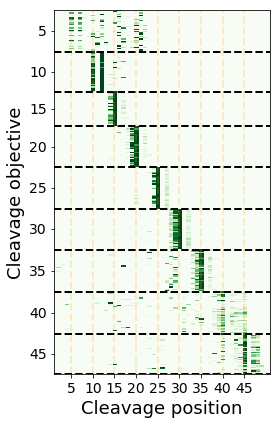

Max cut map


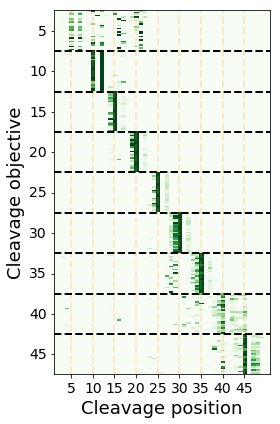

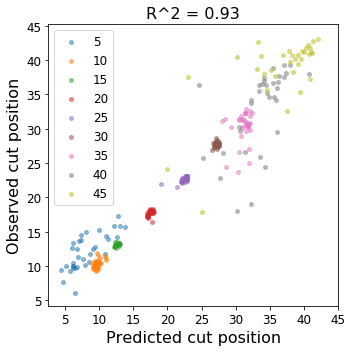

In [8]:
#Mean and Max statistics over AT subexperiments

cut_nt = 'AT'
aruns_objective = ''
ggcc_objective = '_GGCC'
cut_to_subexperiment = {
    5 : [cut_nt + aruns_objective + '_60', cut_nt + aruns_objective + '_ent_60'],
    10 : [cut_nt + aruns_objective + '_65', cut_nt + aruns_objective + '_ent_65'],
    15 : [cut_nt + aruns_objective + '_70', cut_nt + aruns_objective + '_ent_70'],
    20 : [cut_nt + aruns_objective + '_75', cut_nt + aruns_objective + '_ent_75'],
    25 : [cut_nt + aruns_objective + '_80', cut_nt + aruns_objective + '_ent_80'],
    30 : [cut_nt + ggcc_objective + aruns_objective + '_85', cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    35 : [cut_nt + ggcc_objective + aruns_objective + '_90', cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    40 : [cut_nt + ggcc_objective + aruns_objective + '_95', cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    45 : [cut_nt + ggcc_objective + aruns_objective + '_100', cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
}

print('Mean cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=None)#save_fig_name='cut_profile_subexp_at_mean'
print('Max cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=5)#save_fig_name='cut_profile_subexp_at_max'

print('Mean cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=100)#save_fig_name='cut_map_subexp_at_mean'
print('Max cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=25)#save_fig_name='cut_map_subexp_at_max'

plot_position_scatter(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, variant_filter="variant == 'wt' or variant == 'sampled'", figsize=(5, 5), save_fig_name=None, fig_dpi=150)#save_fig_name='avgcut_pred_vs_true_subexp_at'


<h2>Summary Max Cut analysis ('Punish A-runs' subexperiment)</h2>

Mean cut profile


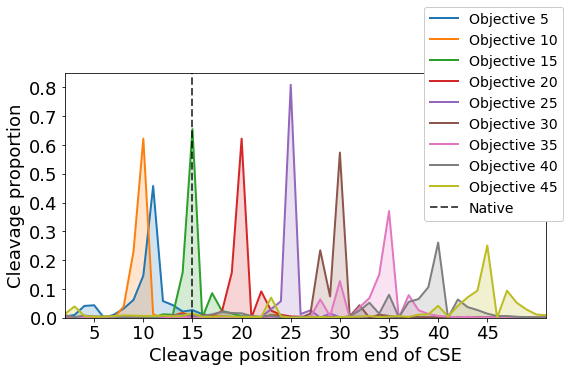

Max cut profile


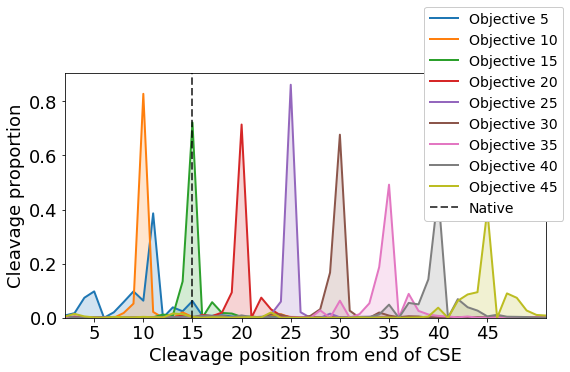

Mean cut map


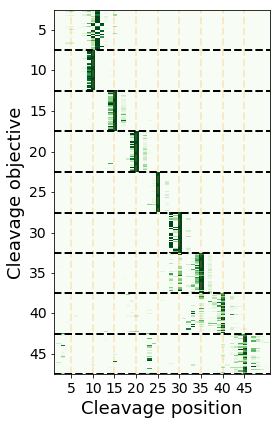

Max cut map


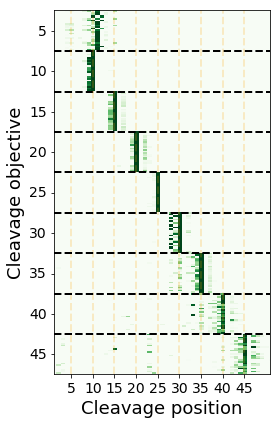

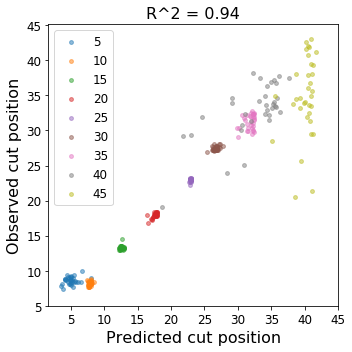

In [9]:
#Mean and Max statistics over A aruns subexperiments

cut_nt = 'A'
aruns_objective = '_aruns'
ggcc_objective = '_GGCC'
cut_to_subexperiment = {
    5 : [cut_nt + aruns_objective + '_60', cut_nt + aruns_objective + '_ent_60'],
    10 : [cut_nt + aruns_objective + '_65', cut_nt + aruns_objective + '_ent_65'],
    15 : [cut_nt + aruns_objective + '_70', cut_nt + aruns_objective + '_ent_70'],
    20 : [cut_nt + aruns_objective + '_75', cut_nt + aruns_objective + '_ent_75'],
    25 : [cut_nt + aruns_objective + '_80', cut_nt + aruns_objective + '_ent_80'],
    30 : [cut_nt + ggcc_objective + aruns_objective + '_85', cut_nt + ggcc_objective + aruns_objective + '_ent_85'],
    35 : [cut_nt + ggcc_objective + aruns_objective + '_90', cut_nt + ggcc_objective + aruns_objective + '_ent_90'],
    40 : [cut_nt + ggcc_objective + aruns_objective + '_95', cut_nt + ggcc_objective + aruns_objective + '_ent_95'],
    45 : [cut_nt + ggcc_objective + aruns_objective + '_100', cut_nt + ggcc_objective + aruns_objective + '_ent_100'],
}

print('Mean cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=None)#save_fig_name='cut_profile_subexp_aruns_mean'
print('Max cut profile')
plot_cut_profile(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(8, 5.5), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=5)#save_fig_name='cut_profile_subexp_aruns_max'

print('Mean cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='mean', n_samples=100)#save_fig_name='cut_map_subexp_aruns_mean'
print('Max cut map')
plot_cut_map(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, figsize=(4, 6), save_fig_name=None, fig_dpi=150, plot_mode='max', n_samples=25)#save_fig_name='cut_map_subexp_aruns_max'

plot_position_scatter(cut_df_filtered, cut_to_subexperiment, cut_poses, objective_poses, human_cutprob, variant_filter="variant == 'wt' or variant == 'sampled'", figsize=(5, 5), save_fig_name=None, fig_dpi=150)#save_fig_name='avgcut_pred_vs_true_subexp_aruns'
